<a href="https://colab.research.google.com/github/Iambusayor/Learn-Jax/blob/main/JAX_101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import jax.numpy as jnp
import numpy as np

# Special transform functions
from jax import grad, jit, vmap, pmap

# JAX's low level API
from jax import lax

from jax import make_jaxpr
from jax import random
from jax import device_put
import matplotlib.pyplot as plt

**Syntax is similar to numpy's**

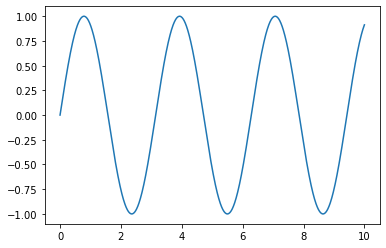

In [2]:
## Syntax is similar to numpy's

x_np = np.linspace(0, 10, 1000)
y_np = 2*np.sin(x_np)*np.cos(x_np)
plt.plot(x_np, y_np)

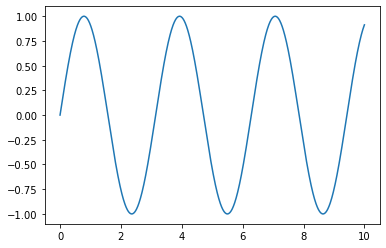

In [3]:
x_jnp = jnp.linspace(0, 10, 1000)
y_jnp = 2*jnp.sin(x_jnp)*jnp.cos(x_jnp)
plt.plot(x_jnp, y_jnp)

In [4]:
## JAX arrays are immutable unlike numpy arrays

x = jnp.arange(10)

## to update the array, we create a new array amd change the value at the index before we compile
y = x.at[0].set(23)
print(x)
print(y)

[0 1 2 3 4 5 6 7 8 9]
[23  1  2  3  4  5  6  7  8  9]


In [5]:
seed = 0
key = random.PRNGKey(seed)

x = random.normal(key, (10,))
print(type(x))
x

<class 'jaxlib.xla_extension.DeviceArray'>


DeviceArray([-0.3721109 ,  0.26423115, -0.18252768, -0.7368197 ,
             -0.44030377, -0.1521442 , -0.67135346, -0.5908641 ,
              0.73168886,  0.5673026 ], dtype=float32)

In [6]:

size = 3000
x_jnp = random.normal(key, (size, size), dtype=jnp.float32)
x_np = np.random.normal(size=(size, size)).astype(np.float32)

"""Comparing processing time between dot product evaluation on jax array and np array"""
%timeit jnp.dot(x_jnp, x_jnp.T).block_until_ready() # on GPU
%timeit np.dot(x_np, x_np.T) # on CPUs [Numpys only work pn CPUs]

"""dot product of np arrays using jax, it creates a bit of an overhead"""
%timeit jnp.dot(x_np, x_np.T).block_until_ready() # GPU transfer overhead 

""" Here we explicitly push the np arrays to gpu before we use jax dot product"""
x_np_device = device_put(x_np) # Push numpy explicitly to GPU
%timeit jnp.dot(x_np_device, x_np_device.T).block_until_ready() # same as #1

""" Jax uses something called asynchronous dispatch system in the background, it allows task delegation to accelerator without runniing it."""
## block_until_ready()-> asynchronous dispatch

The slowest run took 52.47 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 29.6 ms per loop
1 loop, best of 5: 424 ms per loop
10 loops, best of 5: 92.4 ms per loop
10 loops, best of 5: 28.3 ms per loop


' Jax uses something called asynchronous dispatch system in the background, it allows task delegation to accelerator without runniing it.'

# Jax transforms

**jit() compiles functions using XLA and caches them which increases speeeeeeed**

In [7]:
# simple visualization function

def visualize_fn(fn, l=-10, r=10, n=1000):
    x = np.linspace(l, r, num=n)
    y = fn(x)
    # print(x, '\n', y)
    plt.plot(x, y); plt.show()

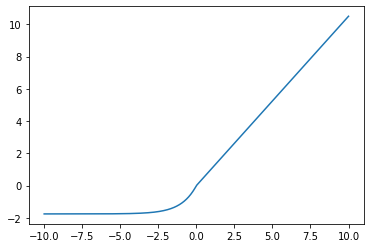

non jit version:
The slowest run took 284.53 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 1.73 ms per loop
jit version:
The slowest run took 633.84 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 5: 214 µs per loop


In [8]:

# Define function
def selu(x, alpha=1.67, lmbda=1.05):
    """ A simple activation function"""
    return lmbda * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

selu_jit = jit(selu) # jit compile

# visualize SELU
visualize_fn(selu)

# benchmarck non-jit vs jit version
data = random.normal(key, (1000000,))

print('non jit version:')
%timeit selu(data).block_until_ready()
print('jit version:')
%timeit selu_jit(data).block_until_ready()

**grad(): used for differentiation such as**

*   **manual**
*   **symbolic**
*   **numeric**
*   **automatic!!**



In [9]:
### automatic diff
def sum_squares(x):
    return jnp.sum(x**2)

x = jnp.arange(3.)
print(x)
loss = sum_squares

## By default grad calculates the derivative of a fn w.r.t 1st parameter
grad_loss = grad(loss)

print(grad_loss(x))

[0. 1. 2.]
[0. 2. 4.]


In [10]:
def finite_differences(f, x):
    eps = 1e-3
    return jnp.array([(f(x + eps * v) - f (x - eps * v)) / (2*eps) for v in jnp.eye(len(x))])

print(finite_differences(loss, x))

[0.        1.9998549 3.9999483]


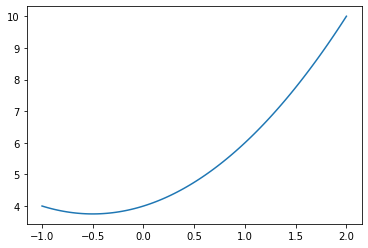

6.0 3.0 2.0 0.0


'It is closer to maths and more powerful compared to .backward() pytorch syntax'

In [11]:
## second example

x = 1.

f = lambda x:x**2 + x + 4 # simple 2nd order polynomial fn
visualize_fn(f, l=-1, r=2, n=100)

dfdx = grad(f) # 2*x+1
d2fdx = grad(dfdx) # 2
d3fdx = grad(d2fdx) # 0

print(f(x), dfdx(x), d2fdx(x), d3fdx(x))
"""It is closer to maths and more powerful compared to .backward() pytorch syntax"""

In [12]:
# for 2 inputs

x = 1.
y = 1.

""" grad only differentiates wrt to the first input"""
f =  lambda x,y : x**2 + x + 4 + y**2 #same simple 2nd order polynomial

dfdx = grad(f) # 2*x+1
d2fdx = grad(dfdx) # 2
d3fdx = grad(d2fdx) # 0

print(f(x, y), dfdx(x, y), d2fdx(x, y), d3fdx(x, y))

""" to diffentiate wrt to y or second input"""
dfdy = grad(f, argnums=(1))
print(f(x, y), dfdy(x, y))



7.0 3.0 2.0 0.0
7.0 2.0


In [13]:
# advanced example

from jax import jacfwd, jacrev
f = lambda x, y:x**2 + y**2  # simple paraboloid, like a cup in 3d space

def hessian(f):
    """ jacfwd works well with tall matrices and jacrev works well with wide mattrices, we use both for optimization """
    return jit(jacfwd(jacrev(f,argnums=(0, 1)), argnums=(0, 1)))

## df/dx = 2x
## d2f/dy = 2y
# J = [df/dx, df/dy]

## d2f/dx = 2
## d2f/dy = 2
## d2f/dxdy = 0
## d2f/dydx = 0
# H = [[d2f/dxdy, d2f/dydx], [d2f/dx, d2f/dy]]

print(f'Jacobian = {jacrev(f, argnums=(0,1))(1.,1.)}')
print(f'Full Hessian = {hessian(f)(1.,1.)}')

Jacobian = (DeviceArray(2., dtype=float32, weak_type=True), DeviceArray(2., dtype=float32, weak_type=True))
Full Hessian = ((DeviceArray(2., dtype=float32, weak_type=True), DeviceArray(0., dtype=float32, weak_type=True)), (DeviceArray(0., dtype=float32, weak_type=True), DeviceArray(2., dtype=float32, weak_type=True)))


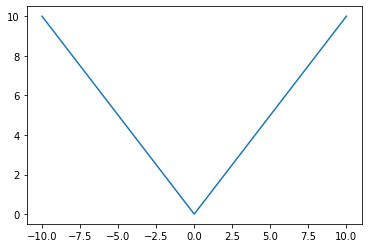

1 1
1.0 -1.0


In [14]:
# Edge case |x| 

f = lambda x: abs(x)
visualize_fn(f)

print(f(-1), f(1))
dfdx = grad(f)
print(dfdx(0.), dfdx(-1.))

**vmap()**

In [15]:
W = random.normal(key, (150, 100))
batched_x = random.normal(key, (10, 100))

def apply_matrix(x):
    return jnp.dot(W, x)  # gonna fail because we're multiplying 150X100  by 10X100

In [16]:
def naively_batched_apply_matrix(batched_x):
    return jnp.stack([apply_matrix(x) for x in batched_x]) # Quite slow, you want to avoid using for loops

print('Naively batched')
%timeit naively_batched_apply_matrix(batched_x).block_until_ready()

Naively batched
The slowest run took 71.06 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 4.66 ms per loop


In [17]:
@jit 
def batched_apply_matrix(batched_x):
    """ the solution here was to transpose  the weights which resulted in a dot multiplcation of (10, 100)*(100, 150) -> (10, 150)"""
    return jnp.dot(batched_x, W.T)

print('Manually batched')
%timeit batched_apply_matrix(batched_x).block_until_ready()


Manually batched
The slowest run took 163.42 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 131 µs per loop


In [18]:
from jax._src.api import block_until_ready

@jit # Using Vmap
def vmap_batched_apply_matrix(batched_x):
    return vmap(apply_matrix)(batched_x)

print("Auto-vectorized with vmap")
%timeit vmap_batched_apply_matrix(batched_x).block_until_ready()

Auto-vectorized with vmap
The slowest run took 146.97 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 140 µs per loop


# **Deeper Dive**
* NumPy <-> lax <-> XLA
* lax API is stricter and more powerful
* it's a python wrapper around XLA

In [19]:
 # Example 1: lax is stricter

print(np.add(1, 1.0))
try:
    print(lax.add(1, 1.0))
except Exception as e:
    print(e)

2.0
lax.add requires arguments to have the same dtypes, got int32, float32. (Tip: jnp.add is a similar function that does automatic type promotion on inputs).
